In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

: 

## 산과 하천 위치의 중심점 삭제

In [2]:
# centroid+구 정보가 붙은 csv 불러오기
def excludeArea(centroids_df, shp_path):
    centroids_gdf = gpd.GeoDataFrame(
        centroids_df,
        geometry=[Point(lon, lat) for lat, lon in zip(centroids_df['centroid_lat'], centroids_df['centroid_lon'])],
        crs='EPSG:4326'
    )

    # 폴리곤 shp
    exclude_gdf = gpd.read_file(shp_path).to_crs('EPSG:4326')

    # 폴리곤 보정 (buffer(0)로 geometry 오류 수정)
    exclude_gdf['geometry'] = exclude_gdf['geometry'].buffer(0)

    # 폴리곤 합치기
    exclude_union = gpd.GeoSeries(
        exclude_gdf.geometry
    ).union_all()

    # centroid가 폴리곤 내부에 있는지 판별
    centroids_gdf['in_exclude'] = centroids_gdf.geometry.apply(lambda x: exclude_union.contains(x))

    # 폴리곤 내부에 있으면 제거
    filtered_gdf = centroids_gdf[~centroids_gdf['in_exclude']].copy()

    filtered_gdf.drop(columns=['in_exclude'], inplace=True)
    return filtered_gdf

In [ ]:
df = pd.read_csv("data/seoul_grid_100m.csv")
df = excludeArea(df, 'data/N3A_E0032111/N3A_E0032111.shp')
df = excludeArea(df, 'data/11/11.shp')

## feature 시각화 및 분석

In [4]:
column_rename_map = {
    '대여수': 'rental_count',
    '반납수': 'return_count',
    '20대': 'age_20s',
    '30대': 'age_30s',
    '40대': 'age_40s',
    'k-전체세대수': 'apart',
}

# 이름 변경
df = df.rename(columns=column_rename_map)

In [5]:
df.describe()

centroid_lat  centroid_lon      isSchool  rental_count  return_count  \
count  44090.000000  44090.000000  44090.000000  44090.000000  44090.000000   
mean      37.547070    126.991519      0.170832     12.392212     12.363982   
std        0.053404      0.093345      0.376367     26.635269     27.193571   
min       37.430890    126.765147      0.000000      0.000000      0.000000   
25%       37.503148    126.915834      0.000000      0.000000      0.000000   
50%       37.545249    127.006832      0.000000      0.000000      0.000000   
75%       37.581632    127.064274      0.000000     14.903226     13.967742   
max       37.695060    127.182561      1.000000    762.870968    773.354839   

              apart  closest_hospital_dist  closest_convenience_dist  \
count  44090.000000           44090.000000              44090.000000   
mean     299.008233             248.372616                135.613160   
std      681.019813             301.600168                193.544239   
min        0.000000               0.468323                  0.129231   
25%        0.000000              84.110956                 45.642016   
50%        0.000000             162.277889                 84.568615   
75%      315.750000             292.372434                154.622328   
max    12032.000000            3224.836534               3040.617223   

       closest_culture_dist       age_20s  ...  subway_avg_board  \
count          44090.000000  44090.000000  ...      44090.000000   
mean             547.148712   4640.786058  ...       1137.207392   
std              479.781627   3779.320906  ...      19113.327845   
min                0.739227    375.706477  ...          0.000000   
25%              266.474742   2342.881743  ...          0.000000   
50%              443.660364   3626.166167  ...          0.000000   
75%              675.314152   5655.767341  ...          0.000000   
max             5004.546773  26533.732667  ...     944401.504857   

       subway_avg_alight        area20        area30        area40  \
count       44090.000000  4.409000e+04  4.409000e+04  4.409000e+04   
mean         1139.458511  1.075427e+05  1.085910e+05  9.431242e+04   
std         19204.429792  2.715781e+05  2.510104e+05  2.097887e+05   
min             0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%             0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
50%             0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
75%             0.000000  1.043878e+05  1.235992e+05  1.198170e+05   
max        937303.504486  3.322530e+06  2.820584e+06  2.717699e+06   

          wp_area20     wp_area30     wp_area40  isCommercial     tow_count  
count  44090.000000  44090.000000  44090.000000    44090.0000  44090.000000  
mean     705.074467   1118.898412    966.637645        0.6467      0.873940  
std     3443.911929   5599.374398   4648.693746        0.4780      4.672653  
min        0.000000      0.000000      0.000000        0.0000      0.000000  
25%        0.000000      0.000000      0.000000        0.0000      0.000000  
50%        0.000000      0.000000      0.000000        1.0000      0.000000  
75%       61.500000    113.750000    131.500000        1.0000      0.000000  
max    47193.250000  81456.500000  63401.500000        1.0000    409.000000  

[8 rows x 30 columns]

### 버스/지하철

In [6]:
zero_bus_board_ratio = (df['bus_avg_board'] == 0).mean() * 100
zero_bus_alight_ratio = (df['bus_avg_alight'] == 0).mean() * 100
zero_sub_board_ratio = (df['subway_avg_board']==0).mean() * 100
zero_sub_alight_ratio = (df['subway_avg_alight']==0).mean() * 100

print(f"버스정류장 비율: {100 - zero_bus_board_ratio}")
print(f"버스 승차 비율: {100 - zero_bus_alight_ratio}")
print(f"지하철 승차 비율: {100 - zero_sub_board_ratio}")
print(f"지하철 승차 비율: {100 - zero_sub_alight_ratio}")

버스정류장 비율: 16.94942163755954
버스 승차 비율: 16.95849398956679
지하철 승차 비율: 0.5556815604445404
지하철 승차 비율: 0.5556815604445404


#### 꼬리가 긴 분포

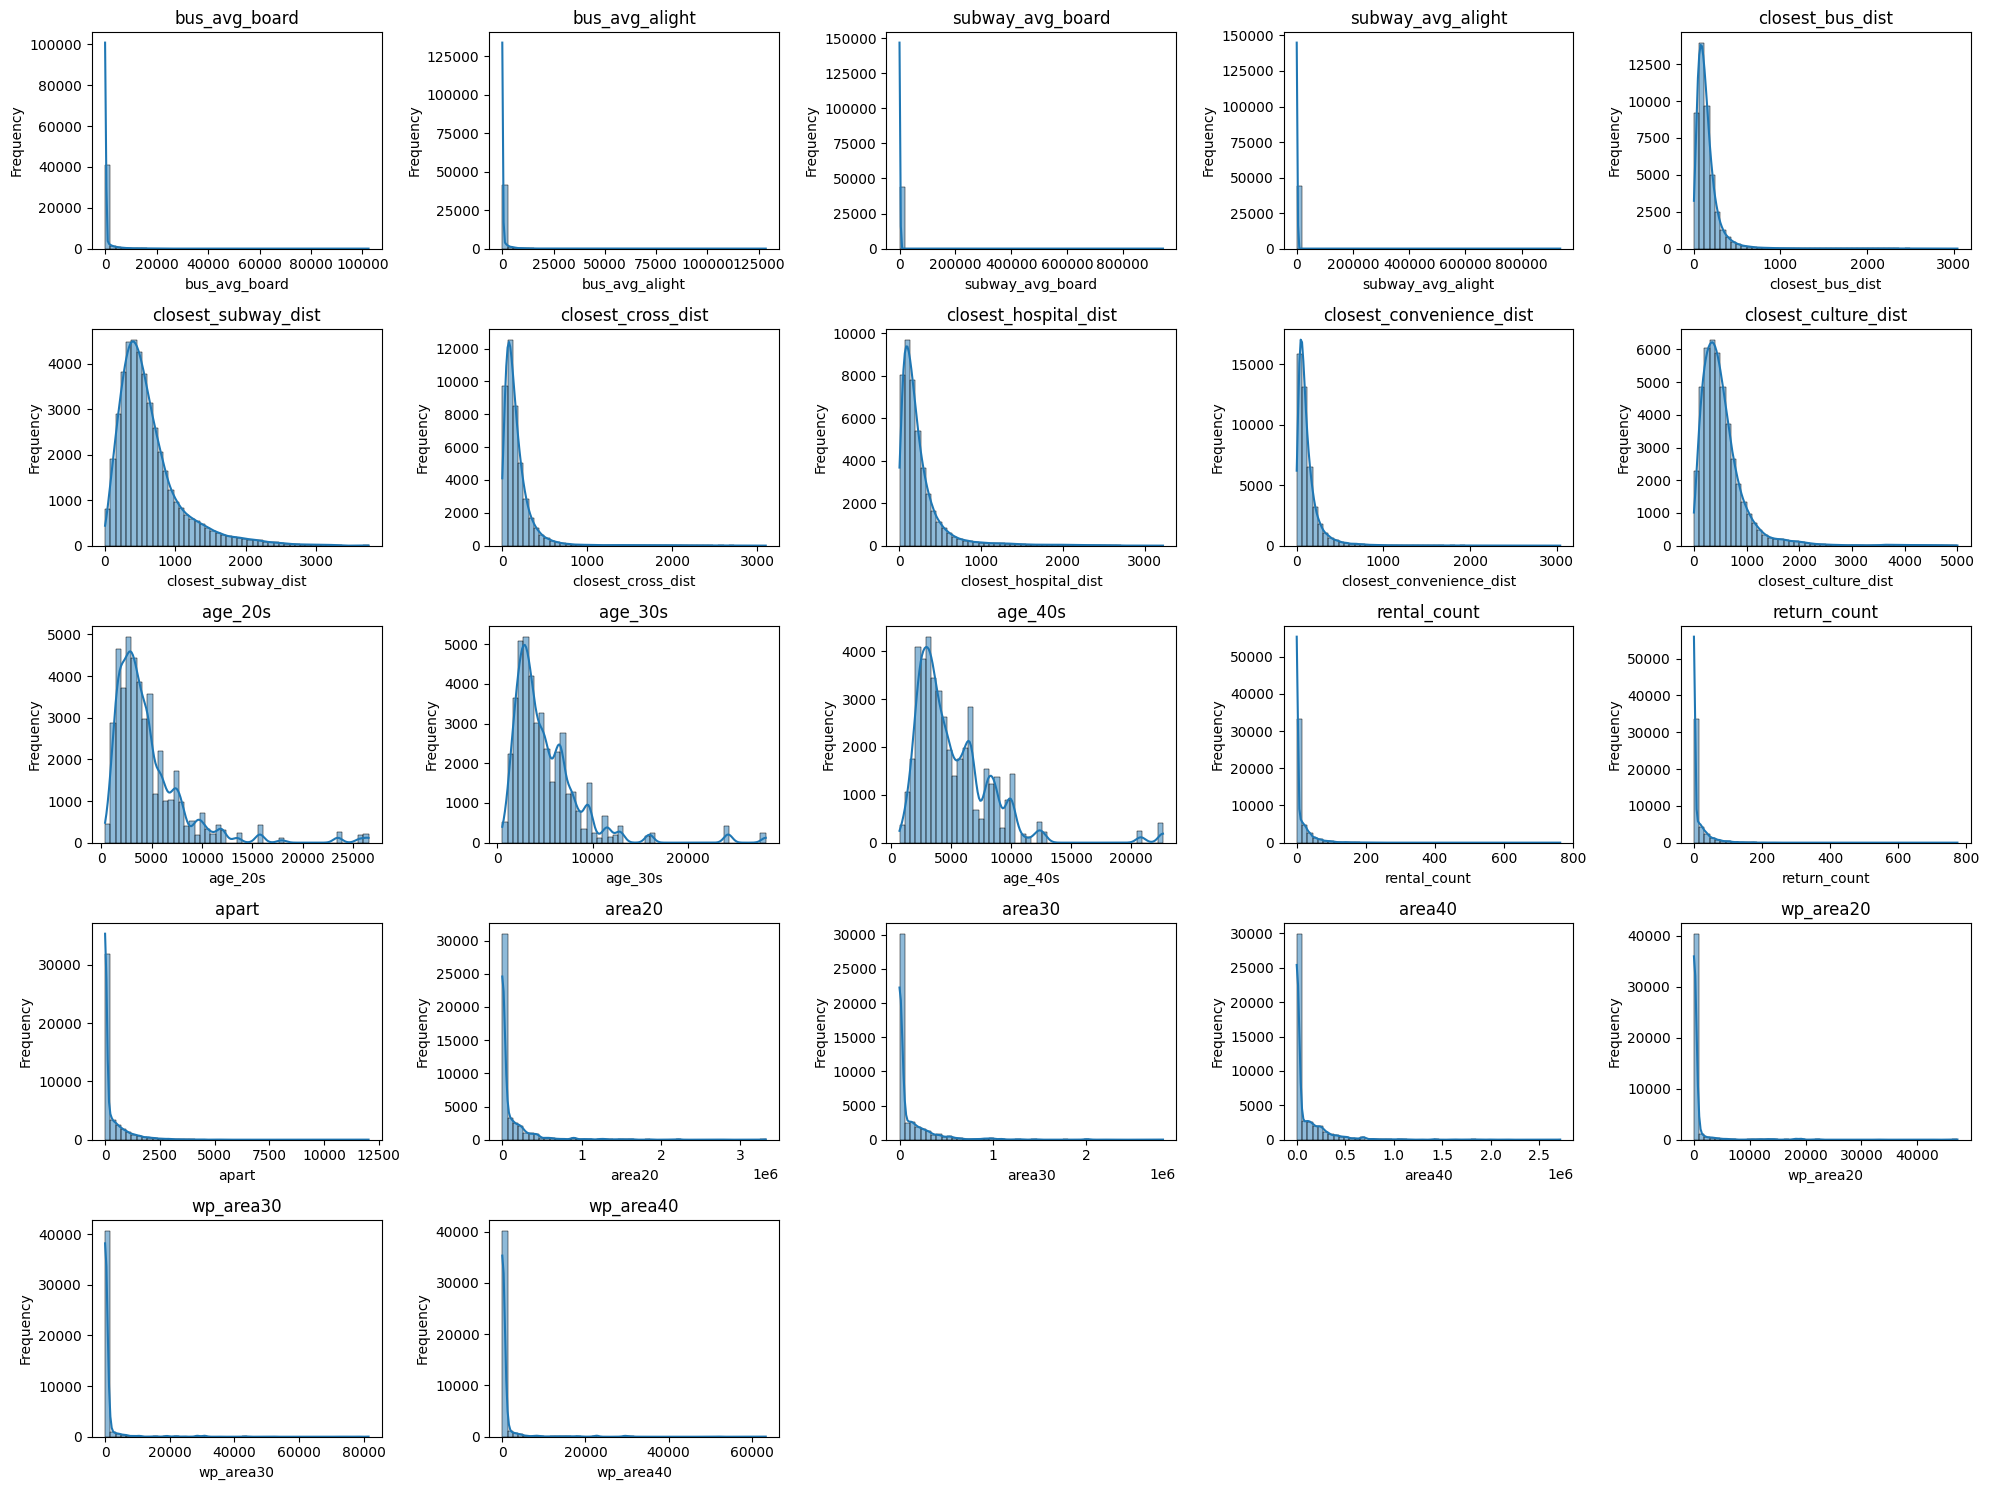

In [7]:
cols = ['bus_avg_board', 'bus_avg_alight', 'subway_avg_board', 'subway_avg_alight',
        'closest_bus_dist', 'closest_subway_dist','closest_cross_dist',
        'closest_hospital_dist', 'closest_convenience_dist', 'closest_culture_dist',
        'age_20s', 'age_30s', 'age_40s', 'rental_count', 'return_count', 'apart','area20', 'area30', 'area40',
           'wp_area20','wp_area30','wp_area40']

plt.figure(figsize=(20, 15))  # 전체 subplot 크기 설정
for i, col in enumerate(cols):
    plt.subplot(5, 5, i + 1)  # 2행 2열 중 i+1번째 subplot
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # subplot 간 여백 자동 조절
plt.show()

#### 극단값이 많으니 로그를 씌워 정규화

In [8]:
df[cols] = df[cols].apply(np.log1p)

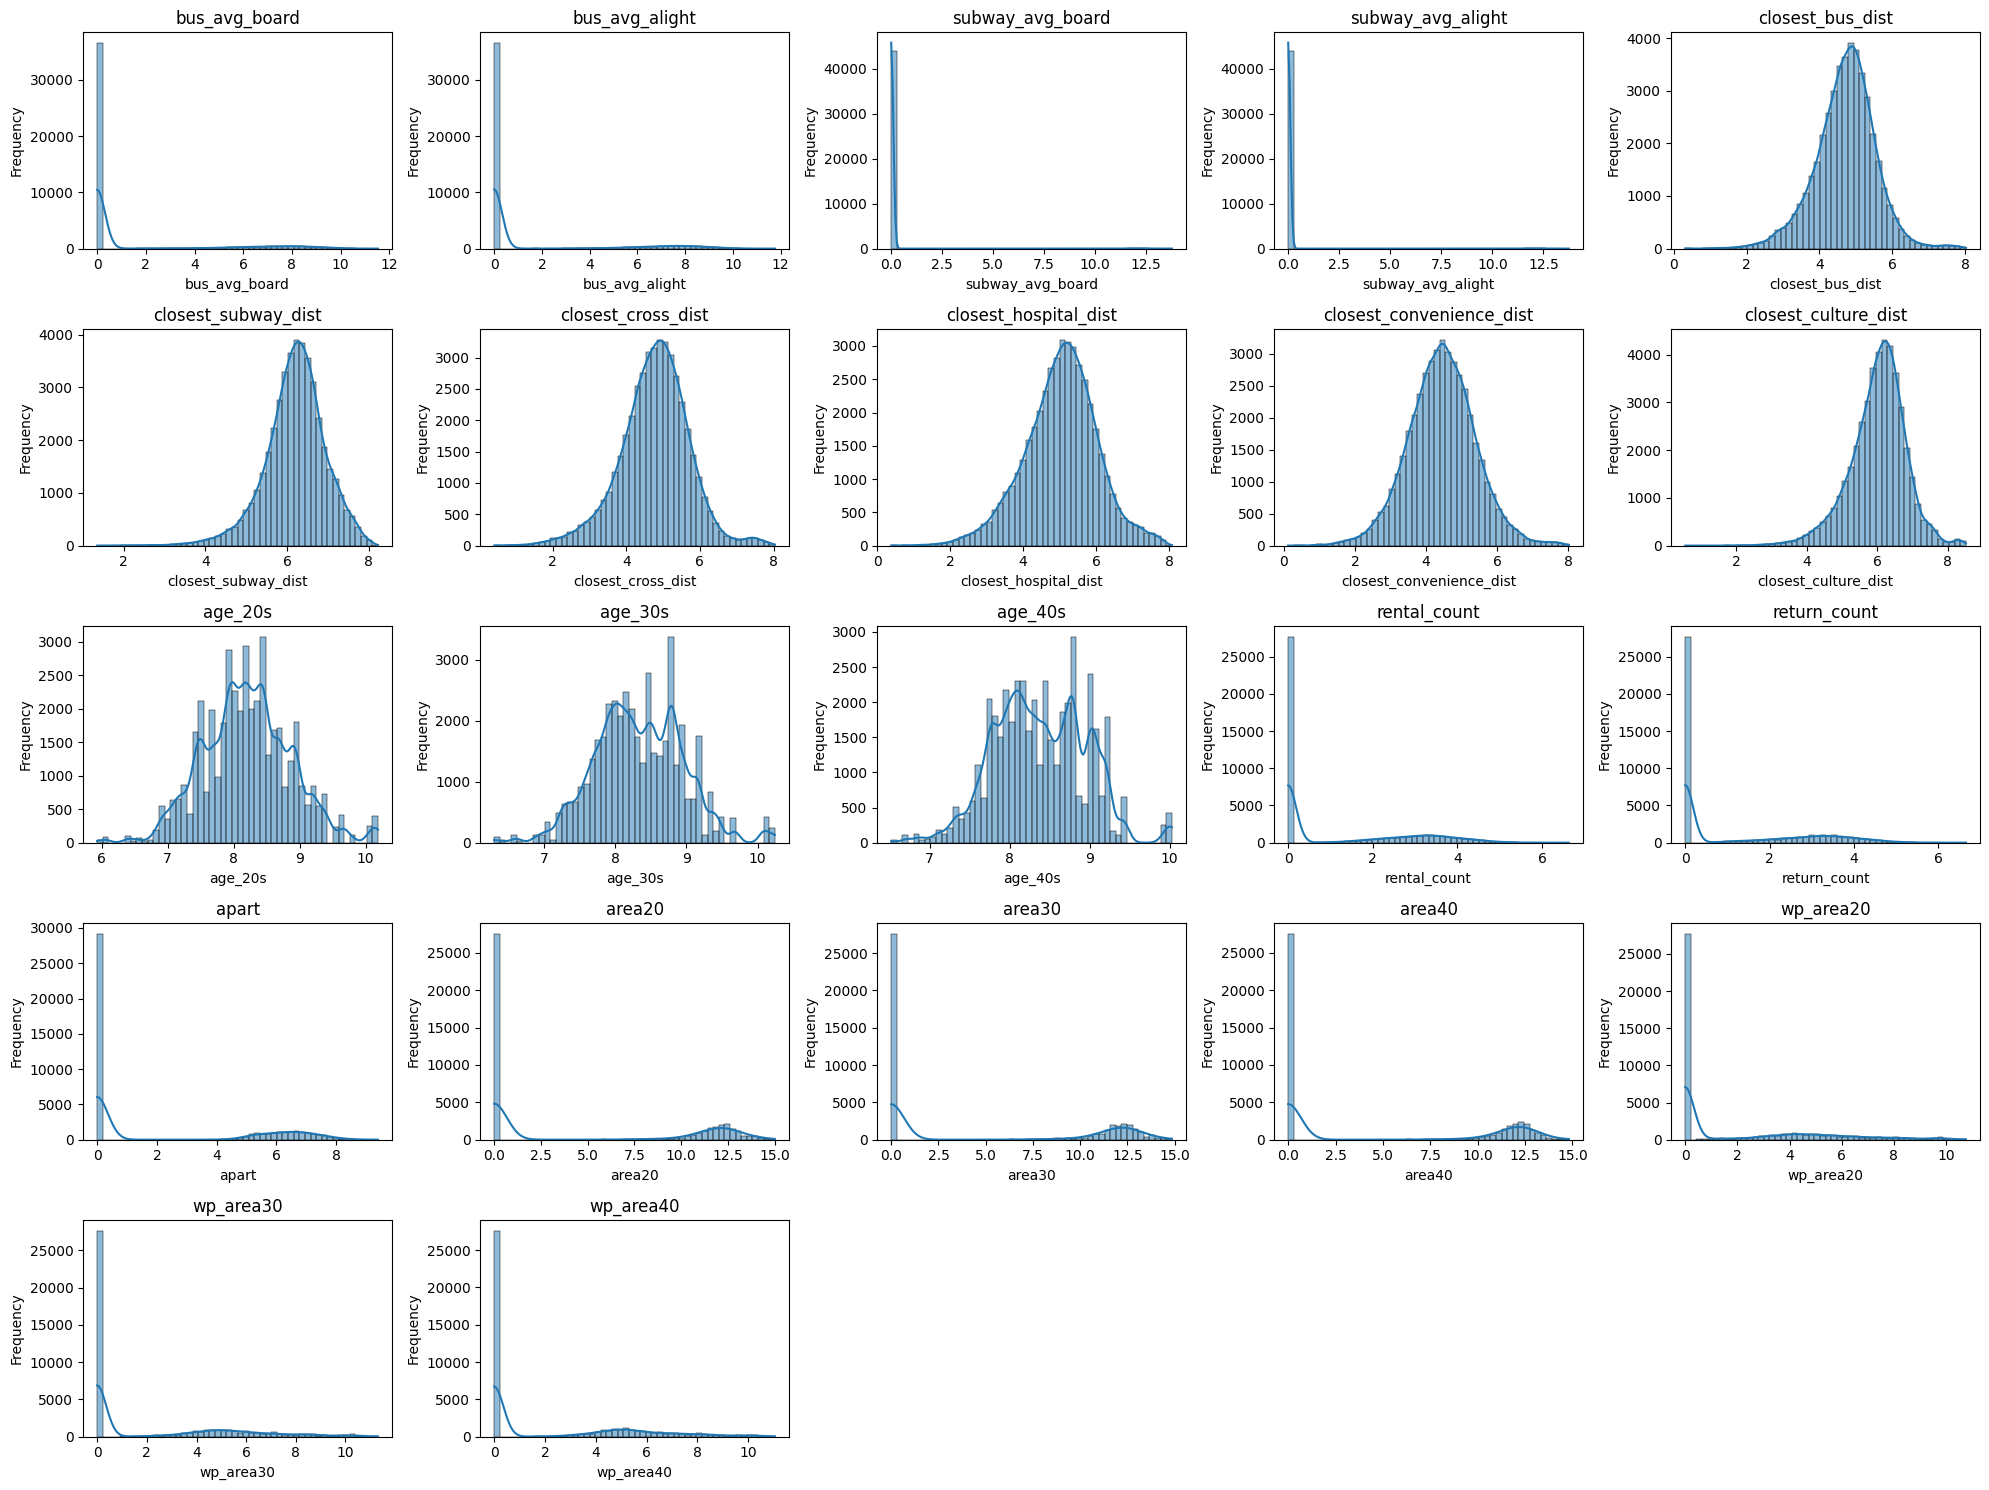

In [9]:
plt.figure(figsize=(20, 15))  # 전체 subplot 크기 설정
for i, col in enumerate(cols):
    plt.subplot(5, 5, i + 1)  # 2행 2열 중 i+1번째 subplot
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # subplot 간 여백 자동 조절
plt.show()

### 파일 저장

In [10]:
df.head()

geometry SIG_KOR_NM  centroid_lat  centroid_lon  \
0  POINT (126.76515 37.55533)        강서구     37.555328    126.765147   
1  POINT (126.76546 37.55577)        강서구     37.555768    126.765465   
2  POINT (126.76622 37.55531)        강서구     37.555308    126.766217   
3  POINT (126.76624 37.55594)        강서구     37.555945    126.766239   
7   POINT (126.76853 37.5526)        강서구     37.552600    126.768528   

   isSchool  rental_count  return_count  apart  closest_hospital_dist  \
0         0           0.0           0.0    0.0               7.955399   
1         0           0.0           0.0    0.0               7.941459   
2         0           0.0           0.0    0.0               7.923215   
3         0           0.0           0.0    0.0               7.915868   
7         0           0.0           0.0    0.0               7.889078   

   closest_convenience_dist  ...  subway_avg_board  subway_avg_alight  area20  \
0                  8.020145  ...               0.0                0.0     0.0   
1                  8.007402  ...               0.0                0.0     0.0   
2                  7.989793  ...               0.0                0.0     0.0   
3                  7.983490  ...               0.0                0.0     0.0   
7                  7.911432  ...               0.0                0.0     0.0   

   area30  area40  wp_area20  wp_area30  wp_area40  isCommercial  tow_count  
0     0.0     0.0        0.0        0.0        0.0             0          0  
1     0.0     0.0        0.0        0.0        0.0             0          0  
2     0.0     0.0        0.0        0.0        0.0             0          0  
3     0.0     0.0        0.0        0.0        0.0             0          0  
7     0.0     0.0        0.0        0.0        0.0             0          0  

[5 rows x 32 columns]

In [ ]:
df.drop(columns=['geometry'], inplace=True)
df.to_csv("data/seoul_preprocessed.csv", index=False)